# Predict more points
* input size = 1
* hidden size = 30
* output size = 24
* mini-batch size = 24

## 1. construct the data set

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data of 39 buildings
df = pd.read_csv('../39个芝加哥办公楼14年6789月.csv')
building_names = df.columns[1:]
load = []
for name in building_names:
    load.append(df[name].values)
load = np.array(load)

# choose one building
data_ori = load[0]

# use max-min normalizaion
maxval = np.max(data_ori)
minval = np.min(data_ori)
data_nor = list(map(lambda x: (x - minval) / (maxval - minval), data_ori))

In [3]:
# parameters:
ifs = 1   # input feature size = 1
hfs = 10  # hidden feature size = 10
pfs =24   # predict feature size = 1
mbs = 24   # mini batch size = 24 (a day)

In [4]:
def multi_pred_navie_dataset(ratio=0.7):
    data_X = data_nor[:-pfs]
    data_Y = []
    
    for i in range(len(data_X)):
        data_Y.append(data_nor[i+1:i+1+pfs])
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % mbs)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % mbs) + train_r
    
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [5]:
[train_X, train_Y, test_X, test_Y] = multi_pred_navie_dataset(0.2)

## 2. define the LSTM model

In [6]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [7]:
class lstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=30, output_size=24, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(1, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(1, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [8]:
model = lstm().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [9]:
train_x = torch.from_numpy(train_X).view(-1, mbs, 1).cuda()
train_y = torch.from_numpy(train_Y).view(-1, mbs, 24).cuda()
test_x = torch.from_numpy(test_X).view(-1, mbs, 1).cuda()
test_y = torch.from_numpy(test_Y).view(-1, mbs, 24).cuda()

In [10]:
%%time
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 0.02625
Epoch: 100, Loss: 0.02578
Epoch: 150, Loss: 0.02513
Epoch: 200, Loss: 0.02520
Epoch: 250, Loss: 0.02328
Epoch: 300, Loss: 0.02311
Epoch: 350, Loss: 0.02389
Epoch: 400, Loss: 0.02671
Epoch: 450, Loss: 0.02416
Epoch: 500, Loss: 0.02304
Epoch: 550, Loss: 0.02322
Epoch: 600, Loss: 0.02243
Epoch: 650, Loss: 0.02160
Epoch: 700, Loss: 0.02262
Epoch: 750, Loss: 0.02119
Epoch: 800, Loss: 0.02125
Epoch: 850, Loss: 0.02138
Epoch: 900, Loss: 0.02137
Epoch: 950, Loss: 0.02083
Epoch: 1000, Loss: 0.02110
Wall time: 10min 2s


## 3. evaluation of this model

In [11]:
import matplotlib.pyplot as plt

In [12]:
model = model.eval()
pred_tensor = model(Variable(test_x))
pred_test = pred_tensor.view(-1).cpu()

In [13]:
pred = pred_test.detach().numpy()
real = test_y.view(-1).cpu().detach().numpy()

In [14]:
diff = []
for i in range(len(real)):
    diff.append((real[i] - pred[i])**2)
print(sum(diff) / len(diff))

0.02668306030311346


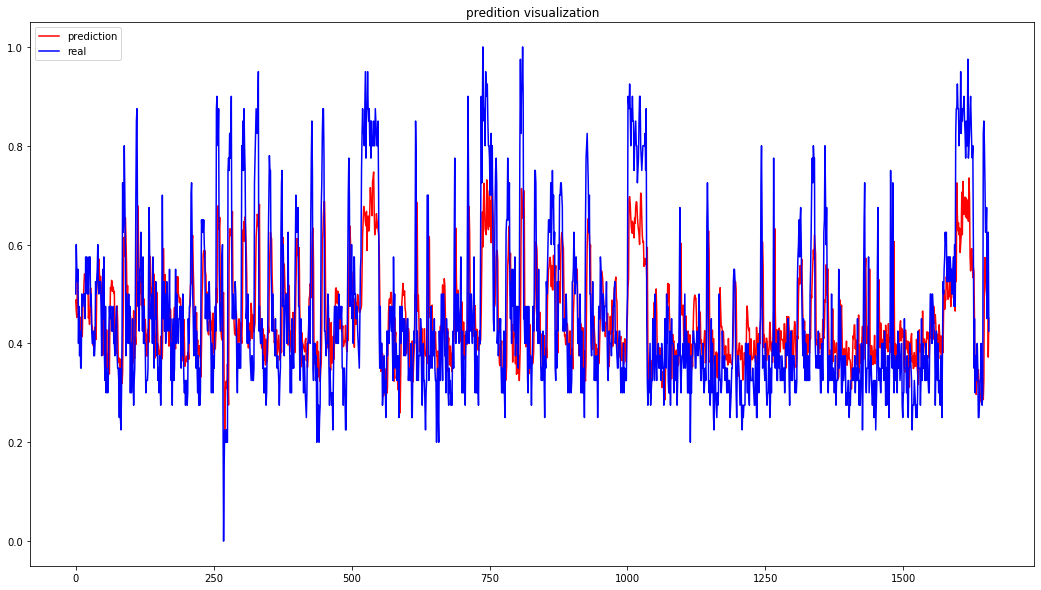

In [15]:
pred_show = [pred[i*24+1] for i in range(int(pred.shape[0] / 24))]
real_show = [real[i*24+1] for i in range(int(real.shape[0] / 24))]
plt.figure(figsize=(18, 10))
plt.title('predition visualization')
plt.plot(pred_show, 'r', label='prediction')
plt.plot(real_show, 'b', label='real')
plt.legend(loc='best')

In [24]:
p = model(Variable(test_x)).cpu().detach().numpy()
r = test_y.cpu().detach().numpy()

p = p.reshape(p.shape[0] * p.shape[1], p.shape[2])
r = r.reshape(r.shape[0] * r.shape[1], r.shape[2])

In [17]:
psum, rsum, pmax, rmax, pmin, rmin = [], [], [], [], [], []

for i in range(p.shape[0]):
    psum.append(sum(p[i]))
    rsum.append(sum(r[i]))
    
    pmax.append(max(p[i]))
    rmax.append(max(r[i]))
    
    pmin.append(min(p[i]))
    rmin.append(min(r[i]))

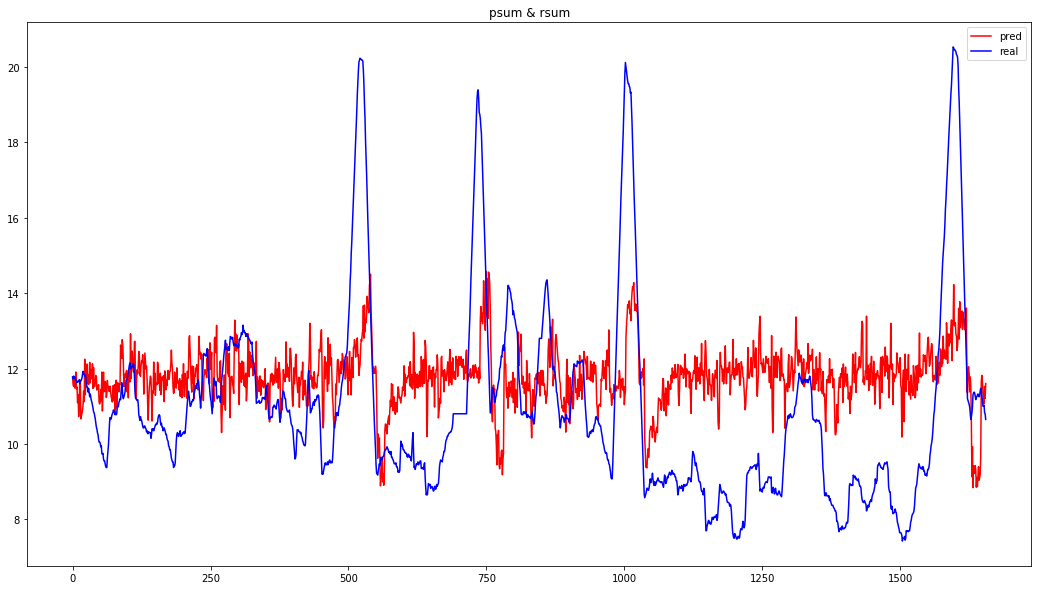

In [18]:
plt.figure(figsize=(18, 10))
plt.title('psum & rsum')
plt.plot(psum, 'r', label='pred')
plt.plot(rsum, 'b', label='real')
plt.legend(loc='best')

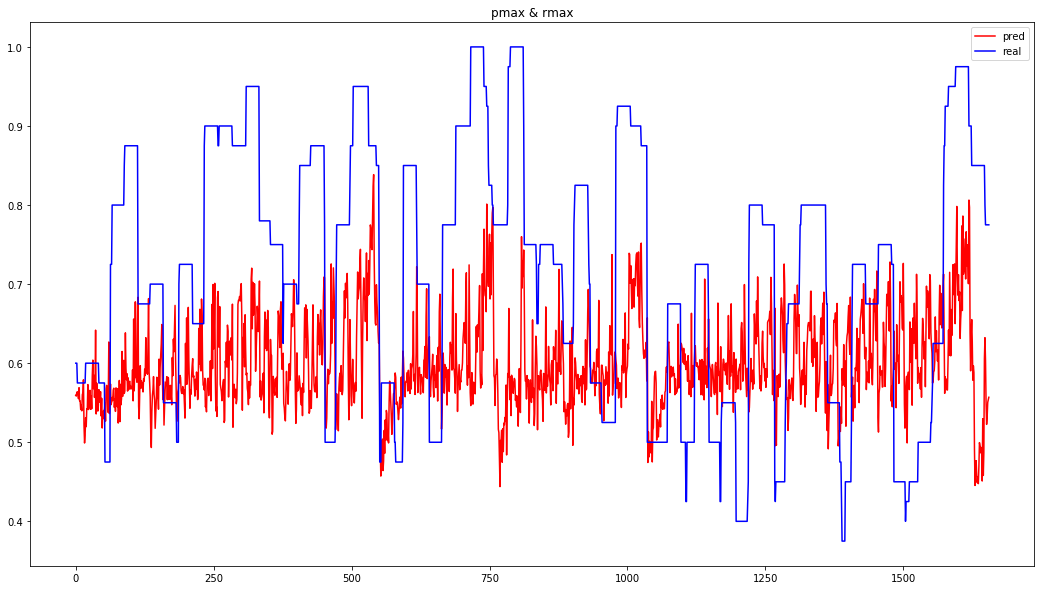

In [19]:
plt.figure(figsize=(18, 10))
plt.title('pmax & rmax')
plt.plot(pmax, 'r', label='pred')
plt.plot(rmax, 'b', label='real')
plt.legend(loc='best')

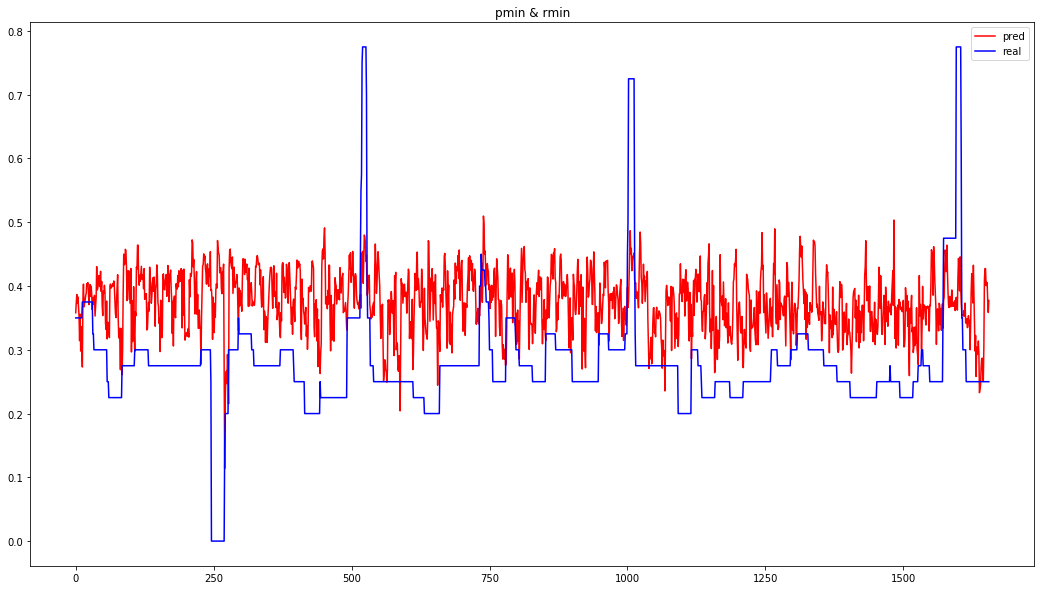

In [20]:
plt.figure(figsize=(18, 10))
plt.title('pmin & rmin')
plt.plot(pmin, 'r', label='pred')
plt.plot(rmin, 'b', label='real')
plt.legend(loc='best')

In [21]:
sumdiff = 0
for i in range(len(psum)):
    sumdiff += (psum[i] - rsum[i]) ** 2
    
sumdiff / len(psum)

6.365278852654979

In [22]:
maxdiff = 0
for i in range(len(pmax)):
    maxdiff += (pmax[i] - rmax[i]) ** 2
    
maxdiff / len(pmax)

0.038852485642241454

In [23]:
mindiff = 0
for i in range(len(pmax)):
    mindiff += (pmin[i] - rmin[i]) ** 2
    
mindiff / len(pmin)

0.017131168072746814